In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import itertools
from functools import partial

import gensim

import text
import util
import intra
from data import gen_topics_from_docs

In [113]:
#cats = ['alt.atheism', 'sci.space', 'sci.med', 'talk.politics.guns', 'comp.graphics']
cats = ['alt.atheism', 'comp.graphics']
ndoc = 400
ntopic = 2
passes = 10
nsel = 10

In [114]:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', shuffle = True, categories=cats)
#newsgroups_test = fetch_20newsgroups(subset='test', shuffle = True)

In [115]:
len(newsgroups_train.data)

1064

In [133]:
docs = newsgroups_train.data[:ndoc]
processed_docs = [lda.preprocess(doc) for doc in docs]
dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [117]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                   num_topics = ntopic,
                                   id2word = dictionary,
                                   passes = passes,
                                   workers = 2)

In [118]:
def extract_topics(topic_val, threshold):
    ts = [t for t, v in topic_val if v >= threshold]
    if len(ts) == 0:
        i = np.argmax([v for t, v in topic_val])
        ts = [topic_val[i][0]]
    return ts


topic_threshold = 0.25
doc2cls = [extract_topics(lda_model[d], topic_threshold) for d in bow_corpus]

In [2]:
import gensim.downloader as api

# fasttext_model300 = api.load('fasttext-wiki-news-subwords-300')
wvmodel = api.load('word2vec-google-news-300')
# glove_model300 = api.load('glove-wiki-gigaword-300')

wv = wvmodel.wv
del wvmodel

[============================================------] 89.3% 1485.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================================-----] 91.8% 1526.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================================---] 95.8% 1593.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================================================--] 97.6% 1622.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================================================-] 98.5% 1637.9/1662.8MB downloaded


/work/modules/Ubuntu/14.04/amd64/common/anaconda3/latest/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/work/modules/Ubuntu/14.04/amd64/common/anaconda3/latest/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [134]:
dv = [np.sum([wv[dictionary[wid]]*cnt for (wid,cnt) in doc if dictionary[wid] in wv.vocab], axis=0) for doc in bow_corpus]

good_idx = [i for i,d in enumerate(dv) if d.shape!=()]
dv = np.stack([dv[i] for i in good_idx])
doc2cls = [doc2cls[i] for i in good_idx]
bow_corpus = [bow_corpus[i] for i in good_idx]
docs = [docs[i] for i in good_idx]
processed_docs = [processed_docs[i] for i in good_idx]

In [138]:
nsel = 10
intra_ = intra.Intra(dv, doc2cls, ntopic, nsel, metric='cosine')

In [139]:
v_ave, v_min, v_max, cls_sel_grv_min = intra_.permutation(1, intra_.greedy_vertex)
print('ave {:.2f}, min {:.2f}, max {:.2f}'.format(v_ave, v_min, v_max))

ave 37.41, min 36.99, max 37.82


In [140]:
f = partial(intra_.local_search, intra=True, print_=False)
v_ave, v_min, v_max, cls_sel_lsi_min = intra_.permutation(1, f)
print('ave {:.2f}, min {:.2f}, max {:.2f}'.format(v_ave, v_min, v_max))

ave 37.42, min 37.00, max 37.84


In [141]:
cls_sel = intra_.greedy_edge()
print('ave: {0:.2f}'.format(np.average(intra_.get_intra_disp(cls_sel))))

ave: 36.33


In [142]:
cls_sel_lsg = intra_.local_search(intra=False)
print('ave: {0:.2f}'.format(np.average(intra_.get_intra_disp(cls_sel_lsg))))

ave of init:  22.998189267118434
iterations: 22
ave: 36.91


In [148]:
nsel = 50
intra_ = intra.Intra(dv, doc2cls, ntopic, nsel, metric='cosine')

In [149]:
v_ave, v_min, v_max, cls_sel_grv_min = intra_.permutation(1, intra_.greedy_vertex)
print('ave {:.2f}, min {:.2f}, max {:.2f}'.format(v_ave, v_min, v_max))

ave 841.81, min 834.22, max 849.39


In [150]:
f = partial(intra_.local_search, intra=True, print_=False)
v_ave, v_min, v_max, cls_sel_lsi_min = intra_.permutation(1, f)
print('ave {:.2f}, min {:.2f}, max {:.2f}'.format(v_ave, v_min, v_max))

ave 842.05, min 834.70, max 849.39


In [151]:
cls_sel = intra_.greedy_edge()
print('ave: {0:.2f}'.format(np.average(intra_.get_intra_disp(cls_sel))))

ave: 829.21


In [152]:
cls_sel_lsg = intra_.local_search(intra=False)
print('ave: {0:.2f}'.format(np.average(intra_.get_intra_disp(cls_sel_lsg))))

ave of init:  593.3613108488767
iterations: 95
ave: 839.99


# pickle

In [7]:
from sklearn.datasets import fetch_20newsgroups

cats = ['alt.atheism', 'sci.space', 'sci.med', 'talk.politics.guns', 'comp.graphics']

for th in [0.15, 0.25]:
    newsgroups_train = fetch_20newsgroups(subset='train', shuffle = True, categories=cats)
    ndoc = len(newsgroups_train.data)
    ntopic = len(cats)
    passes = 20

    gen_topics_from_docs('20newsgroups', newsgroups_train.data, ntopic, passes, th)

ndoc:  2797
processed_docs:  2797
dictionary:  3013


/work/modules/Ubuntu/14.04/amd64/common/anaconda3/latest/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


ndoc:  2797
processed_docs:  2797
dictionary:  3013


# Rest

## MDS

In [143]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1, metric=False)

from scipy.spatial.distance import pdist,squareform
dv_mds = model.fit_transform(squareform(pdist(dv, metric='cosine')))

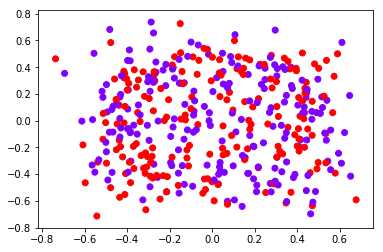

In [144]:
plt.scatter(dv_mds[:, 0], dv_mds[:, 1], c=util.get_colors_by_cls([[cls[0]] for cls in doc2cls]))

In [145]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1, metric=True)

from scipy.spatial.distance import pdist,squareform
dv_mds = model.fit_transform(squareform(pdist(dv, metric='cosine')))

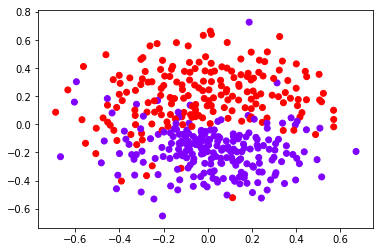

In [146]:
plt.scatter(dv_mds[:, 0], dv_mds[:, 1], c=util.get_colors_by_cls([[cls[0]] for cls in doc2cls]))

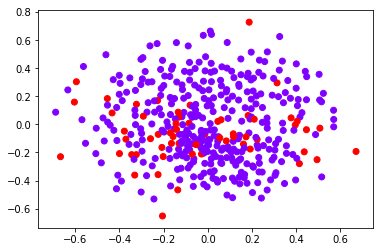

In [147]:
plt.scatter(dv_mds[:, 0], dv_mds[:, 1], c=util.get_colors_by_cls([[len(cls)] for cls in doc2cls]))

## PCA

In [70]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
dv_pca = pca.fit_transform(dv)

In [71]:
len(dv_pca)

1064

In [72]:
dv_pca[0]

array([-6.844851, 11.10399 ], dtype=float32)

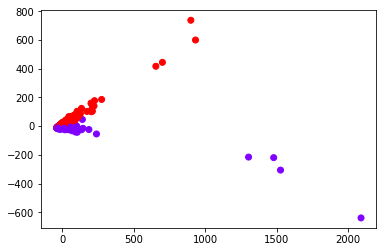

In [75]:
plt.scatter(dv_pca[:,0], dv_pca[:,1], c=util.get_colors_by_cls([[cls[0]] for cls in doc2cls]))
plt.show()

## Topics

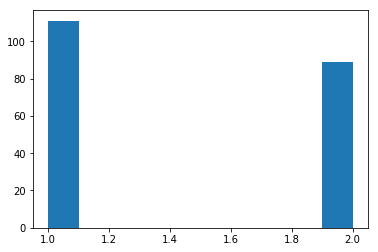

In [109]:
plt.hist([len(cls) for cls in doc2cls])
plt.show()

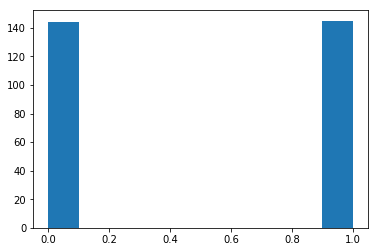

In [110]:
plt.hist(np.concatenate(doc2cls))
plt.show()

In [119]:
lda_model.show_topics(formatted=False)

[(0,
  [('atheism', 0.013223255),
   ('caltech', 0.013113414),
   ('claim', 0.012023207),
   ('morality', 0.0119275935),
   ('evidence', 0.011870407),
   ('islamic', 0.01128032),
   ('wrong', 0.011080404),
   ('value', 0.011015151),
   ('bible', 0.010691029),
   ('islam', 0.010336103)]),
 (1,
  [('color', 0.017629988),
   ('windows', 0.016473522),
   ('draw', 0.014283337),
   ('comp', 0.013681801),
   ('software', 0.012799809),
   ('package', 0.012766585),
   ('email', 0.012199892),
   ('library', 0.012039006),
   ('mail', 0.011996383),
   ('send', 0.011876281)])]

## BOW

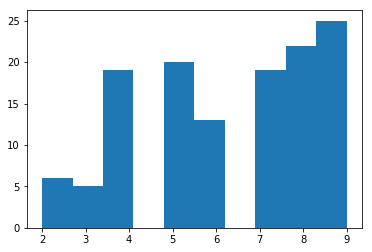

In [26]:
plt.hist([len(b) for b in bow_corpus if len(b)<10])
plt.show()

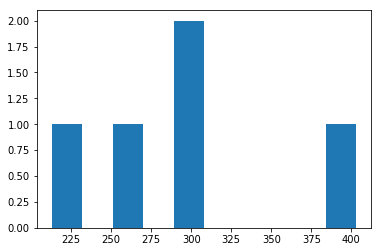

In [27]:
plt.hist([len(b) for b in bow_corpus if len(b)>200])
plt.show()

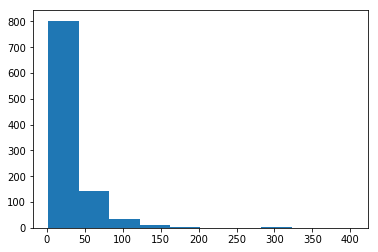

In [28]:
plt.hist([len(b) for b in bow_corpus])
plt.show()